In [ ]:
!pip install roboflow

from roboflow import Roboflow

# authenticate with your API key
rf = Roboflow(api_key="y9hTdcbKlJsH7emPEKU5")

# project name you guessed is correct
project = rf.workspace("pani-edukal").project("non-priority-vehicle-classification-hpg8i")

# choose dataset version (most likely 1)
dataset = project.version(1).download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 76.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Non-Priority-Vehicle-Classification-1 in coco:: 100%|██████████| 4603/4603 [00:02<00:00, 2291.98it/s]


In [ ]:
import json
import pandas as pd

# load the COCO annotation file (train set for example)
with open(dataset.location + "/train/_annotations.coco.json") as f:
    coco_data = json.load(f)

# convert annotations into a dataframe
df = pd.json_normalize(coco_data['annotations'])
print(df.head())


   id  image_id  category_id                      bbox       area  \
0   0         1            5  [124, 157, 345.5, 385.5]  133190.25   
1   1         2            5  [124, 157, 345.5, 385.5]  133190.25   
2   2         3            1      [267, 114, 188, 139]   26132.00   
3   3         4            4     [555, 235, 74.5, 178]   13261.00   
4   4         4            4    [463, 216, 132.5, 231]   30607.50   

  segmentation  iscrowd  
0           []        0  
1           []        0  
2           []        0  
3           []        0  
4           []        0  


In [ ]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())


torch: 2.8.0+cu126
cuda available: False


In [ ]:
# Install Roboflow and COCO tools. Torch + torchvision usually come preinstalled in Colab.
!pip install roboflow pycocotools matplotlib


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="y9hTdcbKlJsH7emPEKU5")  # using the key you provided
project = rf.workspace("pani-edukal").project("non-priority-vehicle-classification-hpg8i")
dataset = project.version(1).download("coco")  # version = 1 (change if another)
print("Dataset downloaded to:", dataset.location)


loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /content/Non-Priority-Vehicle-Classification-1


In [ ]:
import json, os
ann_path = os.path.join(dataset.location, "train", "_annotations.coco.json")
with open(ann_path) as f:
    coco = json.load(f)

print("images:", len(coco['images']))
print("annotations:", len(coco['annotations']))
print("categories:", coco['categories'])

# Create mapping from COCO category_id -> label index (1..N). 0 is background.
cat_ids = [c['id'] for c in coco['categories']]
cat_id_to_label = {cat_id: idx+1 for idx, cat_id in enumerate(cat_ids)}
label_to_name = {idx+1: c['name'] for idx, c in enumerate(coco['categories'])}
num_classes = len(cat_ids) + 1  # +1 for background

print("num_classes (including background):", num_classes)
print("cat_id_to_label sample:", list(cat_id_to_label.items())[:10])


images: 3766
annotations: 5244
categories: [{'id': 0, 'name': 'cars-Ambulance-cars-trucks', 'supercategory': 'none'}, {'id': 1, 'name': 'Ambulance', 'supercategory': 'cars-Ambulance-cars-trucks'}, {'id': 2, 'name': 'Bus', 'supercategory': 'cars-Ambulance-cars-trucks'}, {'id': 3, 'name': 'Car', 'supercategory': 'cars-Ambulance-cars-trucks'}, {'id': 4, 'name': 'Firetruck', 'supercategory': 'cars-Ambulance-cars-trucks'}, {'id': 5, 'name': 'Police cars', 'supercategory': 'cars-Ambulance-cars-trucks'}, {'id': 6, 'name': 'Truck', 'supercategory': 'cars-Ambulance-cars-trucks'}]
num_classes (including background): 8
cat_id_to_label sample: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]


In [ ]:
import torch
from PIL import Image
from pycocotools.coco import COCO
from torchvision.transforms import functional as F
import os

class CocoDetectionTorch(torch.utils.data.Dataset):
    def __init__(self, root, annFile, cat_id_to_label, transforms=None):
        self.coco = COCO(annFile)
        self.root = root
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms
        self.cat_id_to_label = cat_id_to_label

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img = Image.open(os.path.join(self.root, path)).convert("RGB")

        boxes = []
        labels = []
        areas = []
        iscrowd = []
        for a in anns:
            x, y, w, h = a['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_label[a['category_id']])
            areas.append(a.get('area', w*h))
            iscrowd.append(a.get('iscrowd', 0))

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            areas = torch.as_tensor(areas, dtype=torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([img_id])
        target["area"] = areas
        target["iscrowd"] = iscrowd

        # Basic transform: convert to tensor (we'll do it here)
        img = F.to_tensor(img)

        return img, target


In [ ]:
import torch

train_root = os.path.join(dataset.location, "train")
train_ann = os.path.join(train_root, "_annotations.coco.json")

valid_root = os.path.join(dataset.location, "valid")
valid_ann = os.path.join(valid_root, "_annotations.coco.json")

train_ds = CocoDetectionTorch(train_root, train_ann, cat_id_to_label)
valid_ds = CocoDetectionTorch(valid_root, valid_ann, cat_id_to_label)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

print("Train batches:", len(train_loader), " Valid batches:", len(valid_loader))


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train batches: 1883  Valid batches: 275


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace head for our number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:02<00:00, 76.4MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 25   # start small; ramp up if you have time/GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import time
import torch

save_path = "/content/drive/MyDrive/Faster-RCNN.pth"  # final model path in Google Drive

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    iters = 0
    start_time = time.time()

    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # forward + backward
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        iters += 1

        if iters % 50 == 0:  # print every 50 batches
            print(f"[Epoch {epoch+1}] Iter {iters} | Loss: {losses.item():.4f}")

    lr_scheduler.step()
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1}/{num_epochs} completed.")
    print(f"  Avg Loss: {epoch_loss/iters:.4f}")
    print(f"  Time Taken: {epoch_time:.2f} seconds (~{epoch_time/60:.2f} minutes)")

# Save final model in Google Drive
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


[Epoch 1] Iter 50 | Loss: 0.2062
[Epoch 1] Iter 100 | Loss: 0.0731
[Epoch 1] Iter 150 | Loss: 0.1358
[Epoch 1] Iter 200 | Loss: 0.0926
[Epoch 1] Iter 250 | Loss: 0.1124
[Epoch 1] Iter 300 | Loss: 0.1106
[Epoch 1] Iter 350 | Loss: 0.1098
[Epoch 1] Iter 400 | Loss: 0.3453
[Epoch 1] Iter 450 | Loss: 0.0832
[Epoch 1] Iter 500 | Loss: 0.5873
[Epoch 1] Iter 550 | Loss: 0.1054
[Epoch 1] Iter 600 | Loss: 0.4642
[Epoch 1] Iter 650 | Loss: 0.0815
[Epoch 1] Iter 700 | Loss: 0.1329
[Epoch 1] Iter 750 | Loss: 0.2897
[Epoch 1] Iter 800 | Loss: 0.1569
[Epoch 1] Iter 850 | Loss: 0.2032
[Epoch 1] Iter 900 | Loss: 0.1913
[Epoch 1] Iter 950 | Loss: 0.0611
[Epoch 1] Iter 1000 | Loss: 0.1122
[Epoch 1] Iter 1050 | Loss: 0.1327
[Epoch 1] Iter 1100 | Loss: 0.4050
[Epoch 1] Iter 1150 | Loss: 0.1404
[Epoch 1] Iter 1200 | Loss: 0.0682
[Epoch 1] Iter 1250 | Loss: 0.1117
[Epoch 1] Iter 1300 | Loss: 0.1918
[Epoch 1] Iter 1350 | Loss: 0.0581
[Epoch 1] Iter 1400 | Loss: 0.0447
[Epoch 1] Iter 1450 | Loss: 0.3897
[Epoc

In [ ]:
# Make sure model is already created & moved to device:
# model = FasterRCNN(...)
# model.to(device)

# Optimizer (SGD is common for Faster R-CNN)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler (step down LR every few epochs)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [ ]:
import time
import torch
import os
from tqdm import tqdm

num_epochs = 25
save_dir = "/content/drive/MyDrive/FasterRCNN_Checkpoints"
os.makedirs(save_dir, exist_ok=True)

checkpoint_interval = 1  # save every epoch

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    iters = 0
    start_time = time.time()

    # tqdm progress bar for batches (no prints inside loop)
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=True)

    for images, targets in pbar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # forward + backward
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        iters += 1

        # update progress bar with current loss
        pbar.set_postfix({"loss": f"{losses.item():.4f}"})

    lr_scheduler.step()
    epoch_time = time.time() - start_time
    avg_loss = epoch_loss / iters

    print(f"\n✅ Epoch {epoch+1}/{num_epochs} completed | Avg Loss: {avg_loss:.4f} | Time: {epoch_time/60:.2f} min")

    # Save checkpoint
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "lr_scheduler_state_dict": lr_scheduler.state_dict(),
            "loss": avg_loss,
        }, checkpoint_path)
        print(f"💾 Checkpoint saved at {checkpoint_path}")

# Save final model
final_path = os.path.join(save_dir, "FasterRCNN_final.pth")
torch.save({
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "lr_scheduler_state_dict": lr_scheduler.state_dict(),
    "loss": avg_loss,
}, final_path)
print(f"🎉 Final model saved to {final_path}")


Epoch 1/25: 100%|██████████| 1883/1883 [13:12<00:00,  2.38batch/s, loss=0.0809]



✅ Epoch 1/25 completed | Avg Loss: 0.2171 | Time: 13.21 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_1.pth


Epoch 2/25: 100%|██████████| 1883/1883 [13:10<00:00,  2.38batch/s, loss=0.0972]



✅ Epoch 2/25 completed | Avg Loss: 0.1581 | Time: 13.18 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_2.pth


Epoch 3/25: 100%|██████████| 1883/1883 [13:12<00:00,  2.38batch/s, loss=0.0883]



✅ Epoch 3/25 completed | Avg Loss: 0.1366 | Time: 13.20 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_3.pth


Epoch 4/25: 100%|██████████| 1883/1883 [13:12<00:00,  2.38batch/s, loss=0.0173]



✅ Epoch 4/25 completed | Avg Loss: 0.0905 | Time: 13.21 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_4.pth


Epoch 5/25: 100%|██████████| 1883/1883 [13:10<00:00,  2.38batch/s, loss=0.0411]



✅ Epoch 5/25 completed | Avg Loss: 0.0792 | Time: 13.17 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_5.pth


Epoch 6/25: 100%|██████████| 1883/1883 [13:09<00:00,  2.38batch/s, loss=0.0227]



✅ Epoch 6/25 completed | Avg Loss: 0.0726 | Time: 13.16 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_6.pth


Epoch 7/25: 100%|██████████| 1883/1883 [13:11<00:00,  2.38batch/s, loss=0.0628]



✅ Epoch 7/25 completed | Avg Loss: 0.0664 | Time: 13.19 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_7.pth


Epoch 8/25: 100%|██████████| 1883/1883 [13:11<00:00,  2.38batch/s, loss=0.0296]



✅ Epoch 8/25 completed | Avg Loss: 0.0659 | Time: 13.20 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_8.pth


Epoch 9/25: 100%|██████████| 1883/1883 [13:14<00:00,  2.37batch/s, loss=0.0355]



✅ Epoch 9/25 completed | Avg Loss: 0.0652 | Time: 13.24 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_9.pth


Epoch 10/25: 100%|██████████| 1883/1883 [13:14<00:00,  2.37batch/s, loss=0.0267]



✅ Epoch 10/25 completed | Avg Loss: 0.0647 | Time: 13.24 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_10.pth


Epoch 11/25: 100%|██████████| 1883/1883 [13:14<00:00,  2.37batch/s, loss=0.0260]



✅ Epoch 11/25 completed | Avg Loss: 0.0646 | Time: 13.25 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_11.pth


Epoch 12/25: 100%|██████████| 1883/1883 [13:14<00:00,  2.37batch/s, loss=0.0300]



✅ Epoch 12/25 completed | Avg Loss: 0.0644 | Time: 13.25 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_12.pth


Epoch 13/25: 100%|██████████| 1883/1883 [13:15<00:00,  2.37batch/s, loss=0.0215]



✅ Epoch 13/25 completed | Avg Loss: 0.0642 | Time: 13.25 min
💾 Checkpoint saved at /content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_13.pth


Epoch 14/25:  56%|█████▌    | 1052/1883 [07:23<05:48,  2.39batch/s, loss=0.0125]

In [ ]:
# Run this in Colab only. If you're not in Colab skip or adapt.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_13.pth"
OUT_DIR = "/content/drive/MyDrive/FasterRCNN_Eval_Results"
import os
os.makedirs(OUT_DIR, exist_ok=True)


In [ ]:
# basic imports & config
import os, math, json, time
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Config
IOU_THR = 0.5         # for AP@0.5 and matching
SCORE_THR = 0.05      # low threshold to collect predictions (you can filter later)
VIS_SCORE_THR = 0.3   # threshold used for qualitative plots


Using device: cpu


In [ ]:
# optional - for COCO mAP@[.5:.95] evaluation
!pip install pycocotools


In [ ]:
# helpers

def box_iou(boxA, boxB):
    # boxA: (4,) or (N,4) ; boxB: (M,4) -> returns (N,M)
    boxA = np.array(boxA, dtype=float)
    boxB = np.array(boxB, dtype=float)
    if boxA.ndim == 1: boxA = boxA[None, :]
    if boxB.ndim == 1: boxB = boxB[None, :]
    xA = np.maximum(boxA[:, None, 0], boxB[None, :, 0])
    yA = np.maximum(boxA[:, None, 1], boxB[None, :, 1])
    xB = np.minimum(boxA[:, None, 2], boxB[None, :, 2])
    yB = np.minimum(boxA[:, None, 3], boxB[None, :, 3])
    interW = np.maximum(0.0, xB - xA)
    interH = np.maximum(0.0, yB - yA)
    interArea = interW * interH
    areaA = np.clip((boxA[:, 2] - boxA[:, 0]) * (boxA[:, 3] - boxA[:, 1]), a_min=0, a_max=None)
    areaB = np.clip((boxB[:, 2] - boxB[:, 0]) * (boxB[:, 3] - boxB[:, 1]), a_min=0, a_max=None)
    union = areaA[:, None] + areaB[None, :] - interArea
    iou = np.where(union > 0, interArea / union, 0.0)
    return iou

def voc_ap(rec, prec):
    # VOC-style AP (interpolated)
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx+1] - mrec[idx]) * mpre[idx+1])
    return ap

def plot_image_with_boxes(img_tensor, gt_boxes, pred_boxes, pred_labels=None, pred_scores=None, figsize=(10,7)):
    # img_tensor: torch Tensor CxHxW or numpy HxWxC
    if isinstance(img_tensor, torch.Tensor):
        img = img_tensor.cpu().permute(1,2,0).numpy()
    else:
        img = np.array(img_tensor)
    if img.max() > 1.1:
        img = img / 255.0
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    for b in gt_boxes:
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    for i, b in enumerate(pred_boxes):
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        txt = ""
        if pred_labels is not None:
            txt += str(pred_labels[i])
        if pred_scores is not None:
            txt += f" {pred_scores[i]:.2f}"
        ax.text(x1, max(0,y1-8), txt, fontsize=9, bbox=dict(facecolor='yellow', alpha=0.6))
    plt.axis('off')
    plt.show()


In [ ]:
# ----------------- Cell 4: Load checkpoint & instantiate model -----------------
import os
from collections import OrderedDict
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# checkpoint path (change if different)
CHECKPOINT_PATH = "/content/drive/MyDrive/FasterRCNN_Checkpoints/checkpoint_epoch_13.pth"
assert os.path.exists(CHECKPOINT_PATH), f"Checkpoint not found: {CHECKPOINT_PATH}"

# load checkpoint (map to current device)
ckpt = torch.load(CHECKPOINT_PATH, map_location=device)

# extract state_dict whether saved as dict or raw state_dict
if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    state_dict = ckpt["model_state_dict"]
else:
    state_dict = ckpt

# strip 'module.' prefix if present (common if trained with DataParallel)
new_state = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "") if k.startswith("module.") else k
    new_state[new_key] = v
state_dict = new_state

# ensure num_classes exists (should be set earlier from your Roboflow parsing)
if 'num_classes' not in globals():
    # fallback: infer from label_to_name or coco categories if available
    if 'label_to_name' in globals():
        num_classes = max(label_to_name.keys()) + 1  # label_to_name keys are 1..N
    elif 'coco' in globals():
        num_classes = len(coco['categories']) + 1
    else:
        raise RuntimeError("num_classes is not defined. Please set num_classes (including background).")

print("num_classes (including background) =", num_classes)

# build CLASS_NAMES list (index 0 = background)
if 'label_to_name' in globals():
    # label_to_name maps integer label -> name (labels used in your dataset, e.g. 1..N)
    CLASS_NAMES = ["__background__"] + [label_to_name[i] for i in range(1, num_classes)]
elif 'coco' in globals():
    CLASS_NAMES = ["__background__"] + [c['name'] for c in coco['categories']]
else:
    CLASS_NAMES = ["__background__"] + [f"class_{i}" for i in range(1, num_classes)]

print("CLASS_NAMES (0 is background):", CLASS_NAMES)

# instantiate model with same num_classes and load weights
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
try:
    model.load_state_dict(state_dict)
except RuntimeError as e:
    # if there is a mismatch (e.g., final layer shapes differ), show a helpful message
    print("Warning: exact state_dict load failed (likely final head shape mismatch).")
    print("Error:", e)
    # try non-strict load to allow partial loading
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print("Loaded with strict=False. Missing keys:", missing, " Unexpected keys:", unexpected)

model.to(device)
model.eval()
print("Model loaded and set to eval()")
# -------------------------------------------------------------------------------


num_classes (including background) = 8
CLASS_NAMES (0 is background): ['__background__', 'cars-Ambulance-cars-trucks', 'Ambulance', 'Bus', 'Car', 'Firetruck', 'Police cars', 'Truck']


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 76.2MB/s]


Model loaded and set to eval()


In [ ]:
# Cell A: helpers (safe to rerun)
import os, math, json, time
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd

# Ensure OUT_DIR exists
if 'OUT_DIR' not in globals():
    OUT_DIR = "/content/drive/MyDrive/FasterRCNN_Eval_Results"
os.makedirs(OUT_DIR, exist_ok=True)

# IoU
def box_iou(boxA, boxB):
    boxA = np.array(boxA, dtype=float)
    boxB = np.array(boxB, dtype=float)
    if boxA.ndim == 1: boxA = boxA[None, :]
    if boxB.ndim == 1: boxB = boxB[None, :]
    xA = np.maximum(boxA[:, None, 0], boxB[None, :, 0])
    yA = np.maximum(boxA[:, None, 1], boxB[None, :, 1])
    xB = np.minimum(boxA[:, None, 2], boxB[None, :, 2])
    yB = np.minimum(boxA[:, None, 3], boxB[None, :, 3])
    interW = np.maximum(0.0, xB - xA)
    interH = np.maximum(0.0, yB - yA)
    interArea = interW * interH
    areaA = np.clip((boxA[:, 2] - boxA[:, 0]) * (boxA[:, 3] - boxA[:, 1]), a_min=0, a_max=None)
    areaB = np.clip((boxB[:, 2] - boxB[:, 0]) * (boxB[:, 3] - boxB[:, 1]), a_min=0, a_max=None)
    union = areaA[:, None] + areaB[None, :] - interArea
    iou = np.where(union > 0, interArea / union, 0.0)
    return iou

# VOC-style AP
def voc_ap(rec, prec):
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx+1] - mrec[idx]) * mpre[idx+1])
    return ap

# plotting helper
def plot_image_with_boxes(img_tensor, gt_boxes, pred_boxes, pred_labels=None, pred_scores=None, figsize=(10,7)):
    if isinstance(img_tensor, torch.Tensor):
        img = img_tensor.cpu().permute(1,2,0).numpy()
    else:
        img = np.array(img_tensor)
    if img.max() > 1.1:
        img = img / 255.0
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    for b in gt_boxes:
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    for i, b in enumerate(pred_boxes):
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        txt = ""
        if pred_labels is not None:
            txt += str(pred_labels[i])
        if pred_scores is not None:
            txt += f" {pred_scores[i]:.2f}"
        ax.text(x1, max(0,y1-8), txt, fontsize=9, bbox=dict(facecolor='yellow', alpha=0.6))
    plt.axis('off')
    plt.show()


In [ ]:
# Cell B: inference -> collect ground-truths and predictions
assert 'model' in globals(), "model not found. Run cell 4 first to load model."

IOU_THR = 0.5
SCORE_THR = 0.05   # collect predictions with score >= this (low threshold)
VIS_SCORE_THR = 0.3

all_gts = defaultdict(list)   # image_id -> list of {'bbox', 'label'}
predictions = []             # list of {'image_id','bbox','label','score'}

next_image_id = 0
model.eval()
with torch.no_grad():
    for batch in tqdm(valid_loader, desc="Running inference on valid"):
        images, targets = batch   # images: tuple of tensors ; targets: tuple of dicts
        # prepare image ids for the batch
        batch_image_ids = []
        for t in targets:
            if 'image_id' in t:
                try:
                    img_id = int(t['image_id'].item())
                except:
                    # handle shape (1,) etc.
                    img_id = int(t['image_id'][0].item()) if hasattr(t['image_id'], '__len__') else int(t['image_id'])
            else:
                img_id = next_image_id
                next_image_id += 1
            batch_image_ids.append(img_id)

        imgs_cuda = [img.to(device) for img in images]
        outputs = model(imgs_cuda)  # list of dicts

        # collect GTs
        for img_id, t in zip(batch_image_ids, targets):
            boxes = t['boxes'].cpu().numpy()
            labels = t['labels'].cpu().numpy()
            for b, lab in zip(boxes, labels):
                all_gts[img_id].append({'bbox': b.astype(float), 'label': int(lab)})

        # collect predictions (filter by SCORE_THR)
        for img_id, out in zip(batch_image_ids, outputs):
            boxes = out['boxes'].cpu().numpy()
            labels = out['labels'].cpu().numpy()
            scores = out['scores'].cpu().numpy()
            for b, lab, sc in zip(boxes, labels, scores):
                if sc < SCORE_THR:
                    continue
                predictions.append({'image_id': int(img_id), 'bbox': b.astype(float), 'label': int(lab), 'score': float(sc)})

print(f"Collected GTs for {len(all_gts)} images with total GT boxes = {sum(len(v) for v in all_gts.values())}")
print(f"Collected {len(predictions)} predictions (score >= {SCORE_THR})")


Running inference on valid: 100%|██████████| 275/275 [1:01:59<00:00, 13.53s/it]

Collected GTs for 528 images with total GT boxes = 855
Collected 2360 predictions (score >= 0.05)


In [ ]:
# Cell C: AP@0.5 per-class + mAP
eps = 1e-8

# Ensure CLASS_NAMES exists
if 'CLASS_NAMES' not in globals():
    # try to build from label_to_name if available
    if 'label_to_name' in globals():
        CLASS_NAMES = ["__background__"] + [label_to_name[i] for i in range(1, num_classes)]
    else:
        CLASS_NAMES = ["__background__"] + [f"class_{i}" for i in range(1, num_classes)]

# GT count per class
gt_count = defaultdict(int)
for img_id, gts in all_gts.items():
    for g in gts:
        gt_count[g['label']] += 1

# group preds by class and sort by score desc
preds_by_class = defaultdict(list)
for p in predictions:
    preds_by_class[p['label']].append(p)
for cls in preds_by_class:
    preds_by_class[cls].sort(key=lambda x: x['score'], reverse=True)

ap_per_class = {}
pr_curves = {}

for cls in range(1, num_classes):   # skip 0 (background)
    preds = preds_by_class.get(cls, [])
    npos = gt_count.get(cls, 0)
    if npos == 0:
        ap_per_class[cls] = float('nan')
        pr_curves[cls] = (np.array([0.0]), np.array([1.0]))
        continue

    tp = np.zeros(len(preds))
    fp = np.zeros(len(preds))
    matched_per_image = {}  # key: (img_id) -> boolean array for that image's class GTs

    for i, pred in enumerate(preds):
        img_id = pred['image_id']
        pbox = pred['bbox']
        gts = [g for g in all_gts.get(img_id, []) if g['label'] == cls]
        if len(gts) == 0:
            fp[i] = 1
            continue
        gt_boxes = np.array([g['bbox'] for g in gts])
        ious = box_iou(pbox, gt_boxes)[0]
        best_idx = int(np.argmax(ious))
        best_iou = float(ious[best_idx])
        key = img_id
        if key not in matched_per_image:
            matched_per_image[key] = np.zeros(len(gts), dtype=bool)
        if best_iou >= IOU_THR and not matched_per_image[key][best_idx]:
            tp[i] = 1
            matched_per_image[key][best_idx] = True
        else:
            fp[i] = 1

    tp_c = np.cumsum(tp)
    fp_c = np.cumsum(fp)
    rec = tp_c / (npos + eps)
    prec = tp_c / (tp_c + fp_c + eps)
    ap = voc_ap(rec, prec)
    ap_per_class[cls] = ap
    pr_curves[cls] = (rec, prec)

valid_aps = [v for v in ap_per_class.values() if not (isinstance(v, float) and math.isnan(v))]
mAP = float(np.mean(valid_aps)) if len(valid_aps) > 0 else float('nan')

# DataFrame and save
rows = []
for cls in range(1, num_classes):
    name = CLASS_NAMES[cls] if cls < len(CLASS_NAMES) else f"class_{cls}"
    rows.append({'class_idx': cls, 'class_name': name, 'AP@0.5': float(ap_per_class.get(cls, float('nan')))})

df_ap = pd.DataFrame(rows).sort_values('class_idx')
display(df_ap)
df_ap.to_csv(os.path.join(OUT_DIR, "per_class_AP_at_0.5.csv"), index=False)
print(f"mAP@0.5 = {mAP:.4f} | saved per_class_AP_at_0.5.csv -> {OUT_DIR}")


,class_idx,class_name,AP@0.5
0,1,cars-Ambulance-cars-trucks,NaN
1,2,Ambulance,0.893773
2,3,Bus,0.587772
3,4,Car,0.563971
4,5,Firetruck,0.918942
5,6,Police cars,0.969309
6,7,Truck,0.399342


mAP@0.5 = 0.7222 | saved per_class_AP_at_0.5.csv -> /content/drive/MyDrive/FasterRCNN_Eval_Results


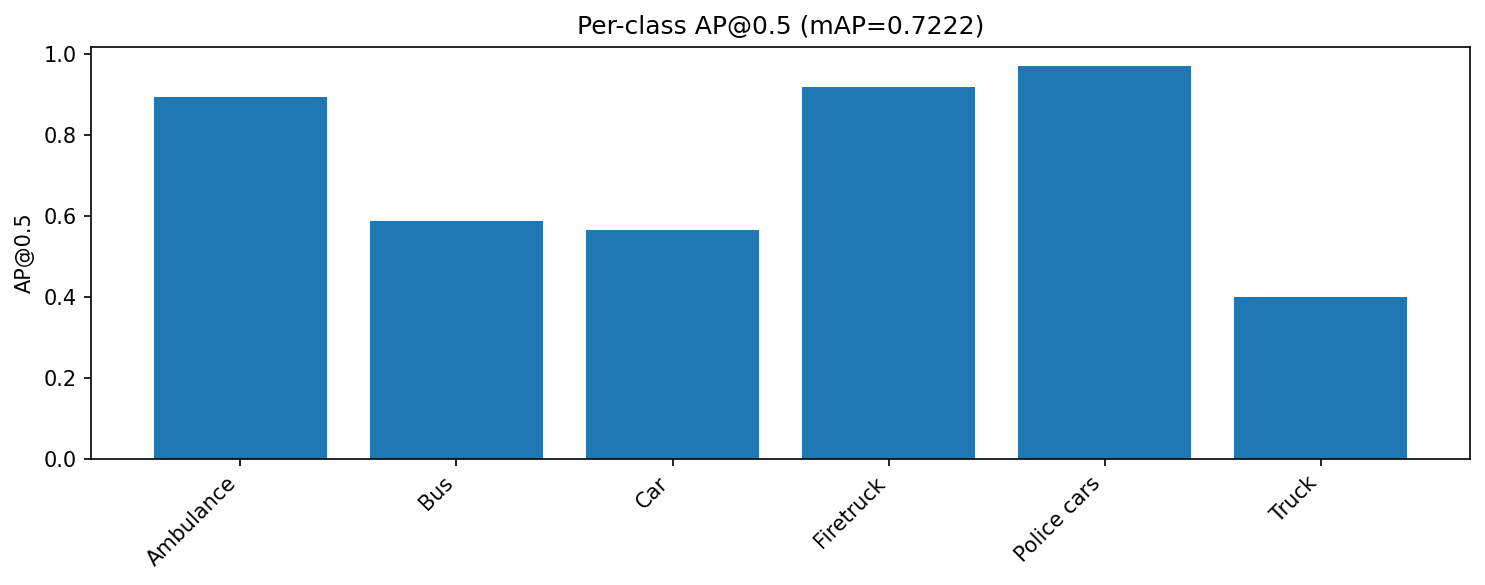

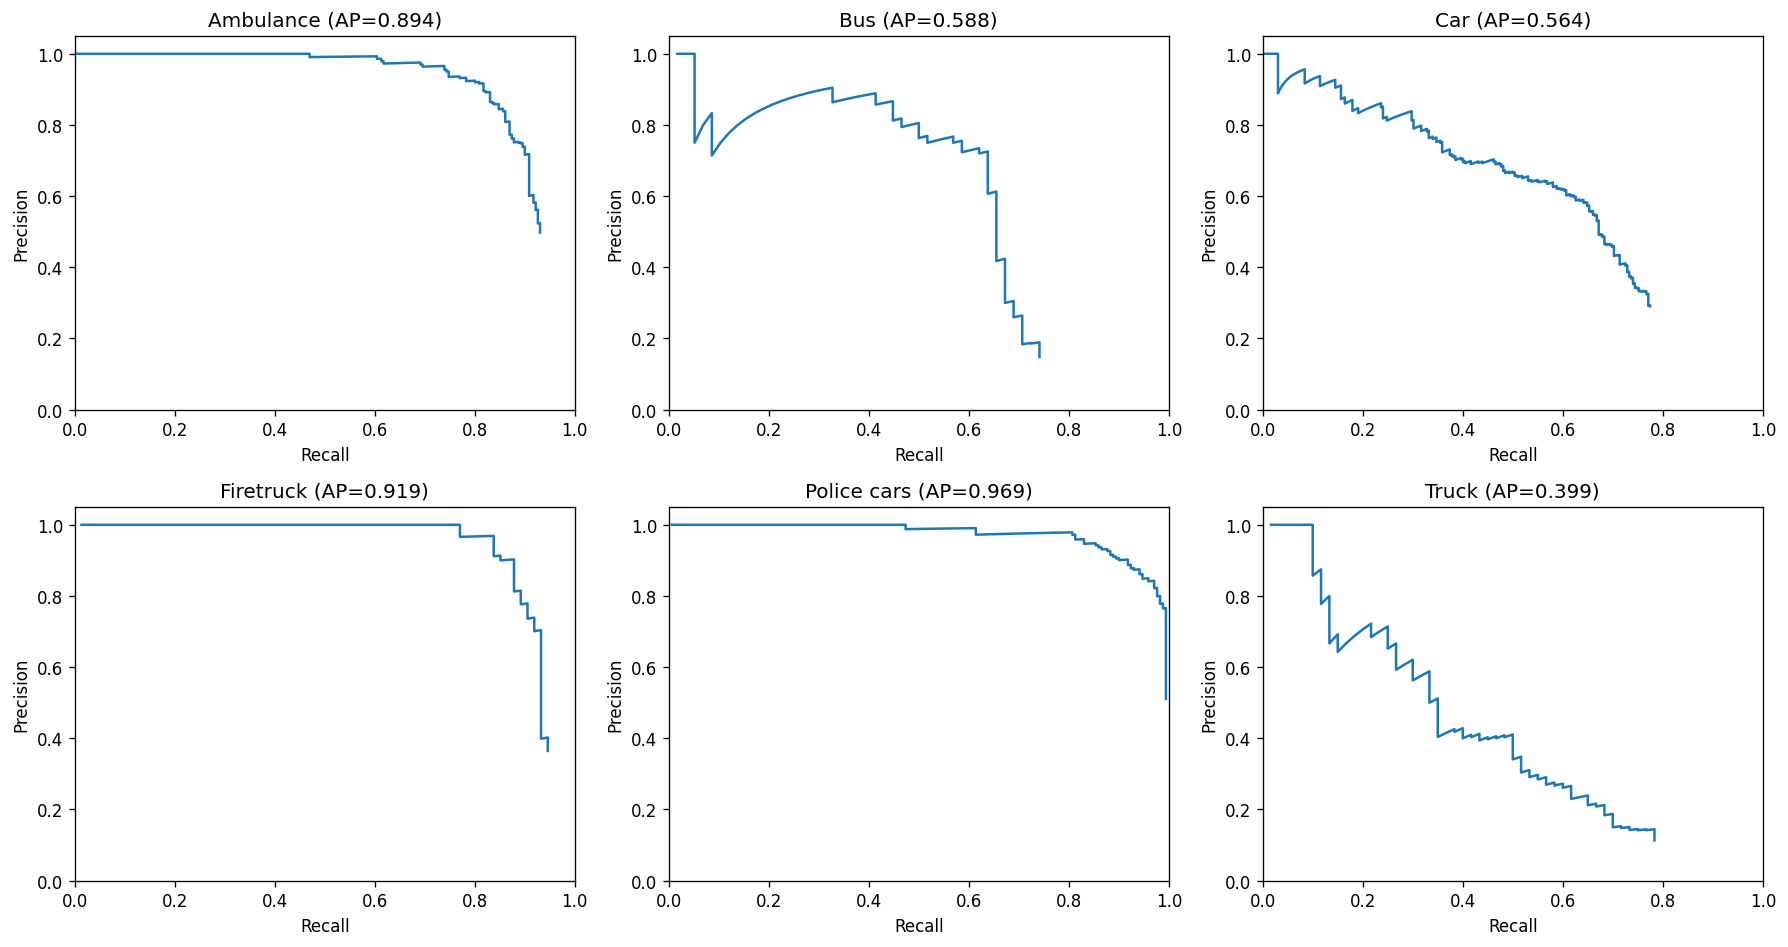

Saved AP bar & PR curves to OUT_DIR


In [ ]:
# Cell D: AP bar plot & PR curves
plot_rows = [r for r in rows if not math.isnan(r['AP@0.5'])]
if len(plot_rows) == 0:
    print("No AP values available to plot.")
else:
    labels = [r['class_name'] for r in plot_rows]
    ap_vals = [r['AP@0.5'] for r in plot_rows]

    plt.figure(figsize=(10,4), dpi=150)
    plt.bar(range(len(ap_vals)), ap_vals)
    plt.xticks(range(len(ap_vals)), labels, rotation=45, ha='right')
    plt.ylabel("AP@0.5")
    plt.title(f"Per-class AP@0.5 (mAP={mAP:.4f})")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "per_class_AP_bar.png"), bbox_inches='tight', dpi=200)
    plt.show()

    # PR curves
    num = len(plot_rows)
    cols = 3
    rows_plots = math.ceil(num / cols)
    plt.figure(figsize=(cols*5, rows_plots*4), dpi=120)
    for i, r in enumerate(plot_rows):
        cls = r['class_idx']
        rec, prec = pr_curves[cls]
        plt.subplot(rows_plots, cols, i+1)
        plt.plot(rec, prec)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{r['class_name']} (AP={r['AP@0.5']:.3f})")
        plt.ylim([0,1.05])
        plt.xlim([0,1.0])
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "PR_curves.png"), bbox_inches='tight', dpi=200)
    plt.show()
    print("Saved AP bar & PR curves to OUT_DIR")


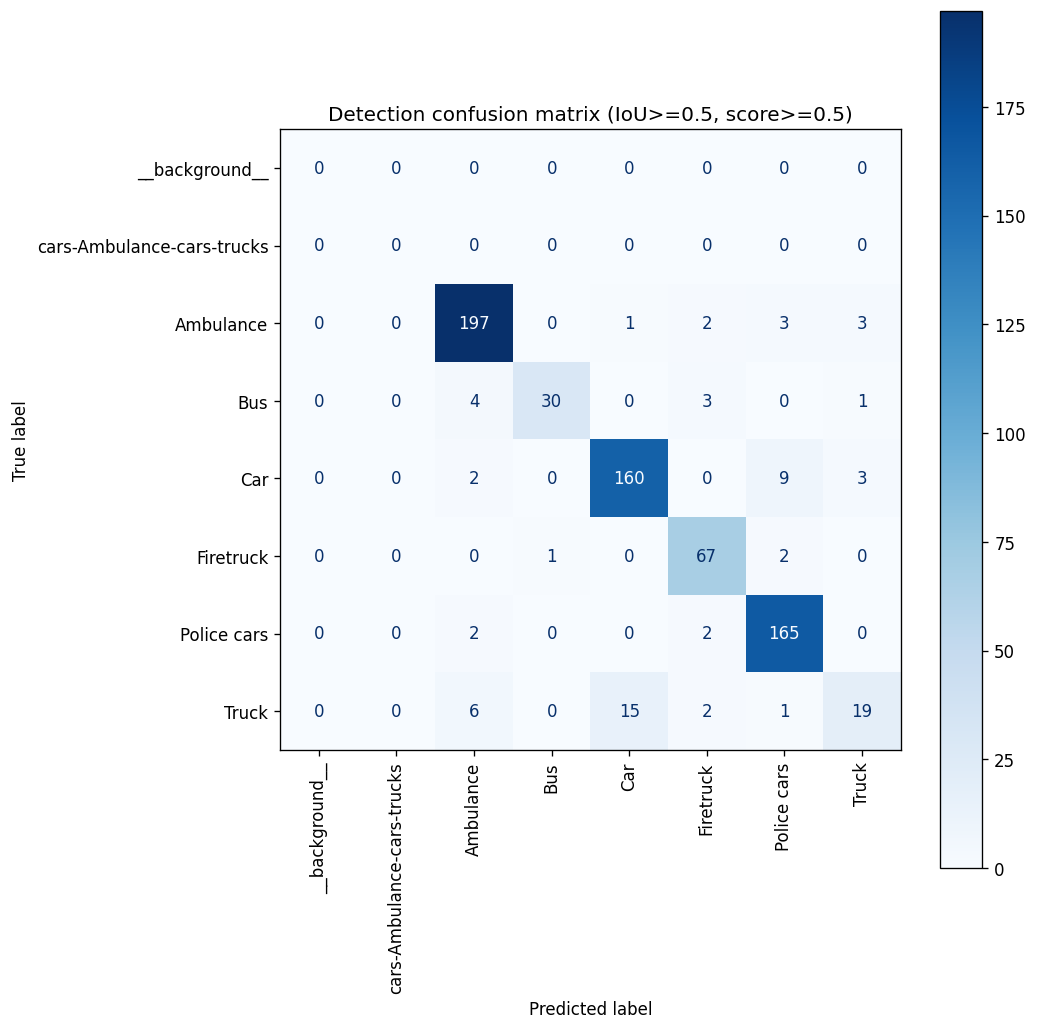

,class_idx,class_name,tp,fp,fn,precision,recall,f1
0,0,__background__,0,0,0,0.000000,0.000000,0.000000
1,1,cars-Ambulance-cars-trucks,0,0,0,0.000000,0.000000,0.000000
2,2,Ambulance,197,31,24,0.864035,0.891403,0.877506
3,3,Bus,30,20,20,0.600000,0.600000,0.600000
4,4,Car,160,108,88,0.597015,0.645161,0.620155
5,5,Firetruck,67,11,4,0.858974,0.943662,0.899329
6,6,Police cars,165,31,2,0.841837,0.988024,0.909091
7,7,Truck,19,22,17,0.463415,0.527778,0.493506


Saved per-class PRF csv to /content/drive/MyDrive/FasterRCNN_Eval_Results


In [ ]:
# Cell E: detection-level confusion & P/R/F1
from sklearn.metrics import ConfusionMatrixDisplay

SCORE_THR_CONF = 0.5  # threshold for counting TP/FP in confusion
num_labels_plot = len(CLASS_NAMES)
cm = np.zeros((num_labels_plot, num_labels_plot), dtype=int)
fp_by_label = np.zeros(num_labels_plot, dtype=int)
fn_by_label = np.zeros(num_labels_plot, dtype=int)

# prepare mutable GTs
gt_mutable = {img_id: [{'bbox': g['bbox'], 'label': g['label'], 'matched': False} for g in gts] for img_id, gts in all_gts.items()}

# sort preds by score desc
preds_sorted = sorted(predictions, key=lambda x: x['score'], reverse=True)
for p in preds_sorted:
    if p['score'] < SCORE_THR_CONF:
        continue
    img_id = p['image_id']
    pbox = p['bbox']
    plabel = p['label']
    gts = gt_mutable.get(img_id, [])
    if len(gts) == 0:
        if plabel < num_labels_plot:
            fp_by_label[plabel] += 1
        continue
    gt_boxes = np.array([g['bbox'] for g in gts])
    ious = box_iou(pbox, gt_boxes)[0]
    best_idx = int(np.argmax(ious))
    best_iou = float(ious[best_idx])
    if best_iou >= IOU_THR and not gts[best_idx]['matched']:
        glabel = gts[best_idx]['label']
        if glabel < num_labels_plot and plabel < num_labels_plot:
            cm[glabel, plabel] += 1
        gts[best_idx]['matched'] = True
    else:
        if plabel < num_labels_plot:
            fp_by_label[plabel] += 1

# unmatched GTs -> FN
for img_id, gts in gt_mutable.items():
    for g in gts:
        if not g['matched']:
            if g['label'] < num_labels_plot:
                fn_by_label[g['label']] += 1

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(9,9), dpi=120)
disp.plot(ax=ax, xticks_rotation='vertical', cmap=plt.cm.Blues)
plt.title(f"Detection confusion matrix (IoU>={IOU_THR}, score>={SCORE_THR_CONF})")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"), dpi=200, bbox_inches='tight')
plt.show()

# per-class PRF
metrics_rows = []
for idx, name in enumerate(CLASS_NAMES):
    tp = int(cm[idx, idx])
    fp = int(fp_by_label[idx])
    fn = int(fn_by_label[idx])
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    metrics_rows.append({'class_idx': idx, 'class_name': name, 'tp': tp, 'fp': fp, 'fn': fn,
                         'precision': float(precision), 'recall': float(recall), 'f1': float(f1)})

df_metrics = pd.DataFrame(metrics_rows)
display(df_metrics)
df_metrics.to_csv(os.path.join(OUT_DIR, f"per_class_PRF_at_{SCORE_THR_CONF}.csv"), index=False)
print(f"Saved per-class PRF csv to {OUT_DIR}")


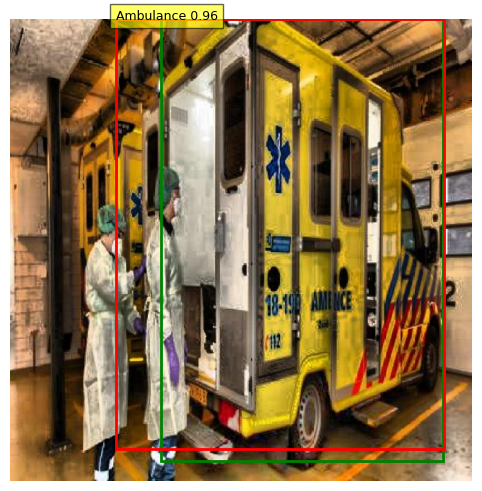

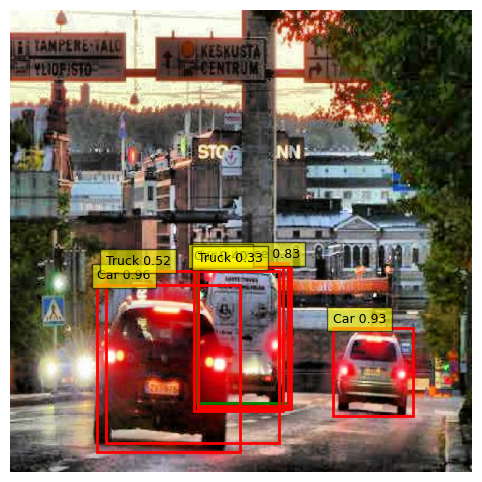

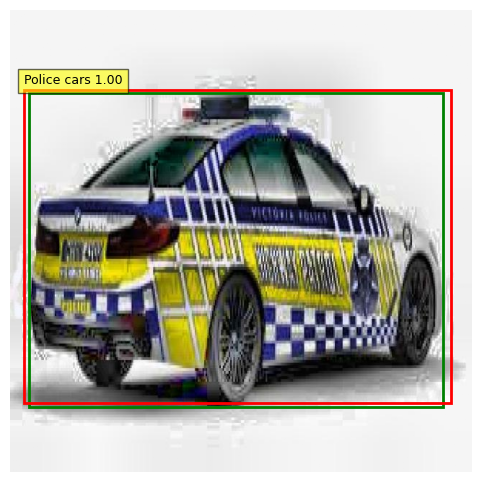

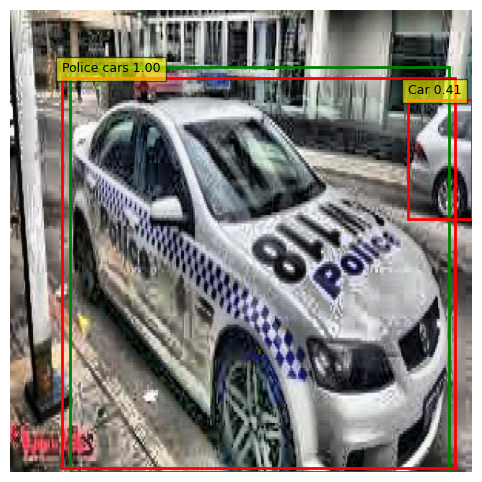

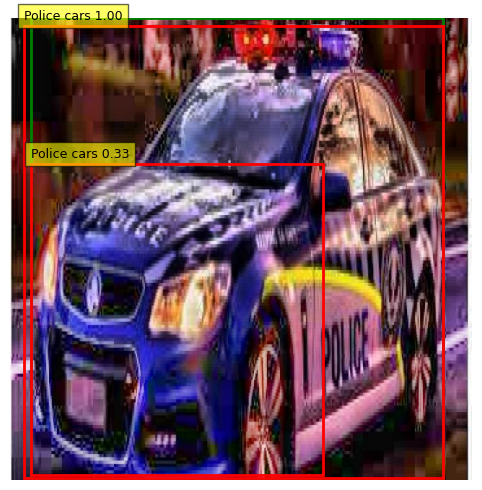

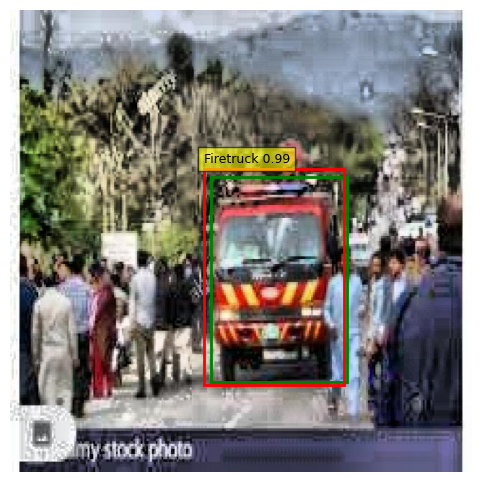

In [ ]:
# Cell F: qualitative visualizations (uses valid_loader.dataset)
dataset_obj = getattr(valid_loader, 'dataset', None)
if dataset_obj is None:
    print("valid_loader.dataset not found; can't plot raw images. If you indexed images via dataset, attach it to valid_loader.dataset.")
else:
    N = 6
    shown = 0
    for idx in range(len(dataset_obj)):
        sample = dataset_obj[idx]
        if not isinstance(sample, (tuple, list)) or len(sample) < 2:
            continue
        img, tgt = sample[0], sample[1]
        # get image id:
        try:
            img_id = int(tgt['image_id'].item())
        except:
            try:
                img_id = int(tgt['image_id'][0].item())
            except:
                img_id = idx
        gts = [g['bbox'] for g in all_gts.get(img_id, [])]
        preds_for_img = [p for p in predictions if p['image_id'] == img_id and p['score'] >= VIS_SCORE_THR]
        pred_boxes = [p['bbox'] for p in preds_for_img]
        pred_labels = [CLASS_NAMES[p['label']] if p['label'] < len(CLASS_NAMES) else f"class_{p['label']}" for p in preds_for_img]
        pred_scores = [p['score'] for p in preds_for_img]
        plot_image_with_boxes(img, gts, pred_boxes, pred_labels, pred_scores, figsize=(10,6))
        shown += 1
        if shown >= N:
            break


In [ ]:
# Cell G: save predictions CSV and JSON summary
pred_df = pd.DataFrame([{'image_id': p['image_id'], 'x1':p['bbox'][0], 'y1':p['bbox'][1], 'x2':p['bbox'][2], 'y2':p['bbox'][3],
                         'label': p['label'], 'label_name': (CLASS_NAMES[p['label']] if p['label'] < len(CLASS_NAMES) else f"class_{p['label']}"),
                         'score': p['score']} for p in predictions])
pred_df.to_csv(os.path.join(OUT_DIR, "predictions.csv"), index=False)

summary = {
    'mAP@0.5': float(mAP),
    'num_eval_images': len(all_gts),
    'num_gt_boxes': sum(len(v) for v in all_gts.values()),
    'num_predictions': len(predictions)
}
with open(os.path.join(OUT_DIR, "eval_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Saved predictions.csv and eval_summary.json ->", OUT_DIR)


Saved predictions.csv and eval_summary.json -> /content/drive/MyDrive/FasterRCNN_Eval_Results


V2- 74 TO 90

In [ ]:
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 674346, done.
remote: Counting objects: 100% (757/757), done.
remote: Compressing objects: 100% (707/707), done.
remote: Total 674346 (delta 670), reused 89 (delta 46), pack-reused 673589 (from 2)
Receiving objects: 100% (674346/674346), 1.19 GiB | 38.27 MiB/s, done.
Resolving deltas: 100% (631451/631451), done.


In [ ]:
import math
import sys
import time
import torch

# Simple metric logger (to mimic TorchVision utils)
class SmoothedValue(object):
    def __init__(self, window_size=20):
        self.deque = []
        self.total = 0.0
        self.count = 0
        self.window_size = window_size

    def update(self, value, n=1):
        self.deque.append(value)
        self.total += value * n
        self.count += n
        if len(self.deque) > self.window_size:
            self.deque.pop(0)

    @property
    def avg(self):
        return sum(self.deque) / len(self.deque) if self.deque else 0

    @property
    def global_avg(self):
        return self.total / self.count if self.count else 0


class MetricLogger(object):
    def __init__(self):
        self.meters = {}

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if k not in self.meters:
                self.meters[k] = SmoothedValue()
            self.meters[k].update(v)

    def __str__(self):
        return " | ".join(f"{k}: {meter.avg:.4f}" for k, meter in self.meters.items())


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    metric_logger = MetricLogger()

    lr_scheduler = None
    if epoch == 1:  # Warmup learning rate
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for i, (images, targets) in enumerate(data_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses.item())

        if i % print_freq == 0:
            print(f"Epoch [{epoch}] Iter [{i}/{len(data_loader)}] | {metric_logger}")

    return metric_logger


In [ ]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    metric_logger = MetricLogger()

    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)
        metric_logger.update(num_samples=len(images))

    print(f"Evaluation results: {metric_logger}")
    return metric_logger


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with new one (num_classes includes background)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [ ]:
import torch

# Pick GPU if available, otherwise fallback to CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
num_classes = 6  # adjust based on your dataset
model = get_model(num_classes)
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ------------------------------
# Device
# ------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

# ------------------------------
# Model
# ------------------------------
def get_model(num_classes):
    # Load a pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the head with a new one for our dataset
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

num_classes = 6   # 5 classes + background
model = get_model(num_classes)
model.to(device)


Using device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch
import os
import numpy as np
import torchvision
from PIL import Image
import xml.etree.ElementTree as ET

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")

        # Parse annotation
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            labels.append(int(label))  # assumes label is already integer
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [ ]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [ ]:
import os

print("Train folder contents:")
print(os.listdir("/content/dataset/train"))

print("\nTest folder contents:")
print(os.listdir("/content/dataset/test"))


Train folder contents:


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/train'